# Comprehend

In [1]:
import configparser
import boto3
import pandas as pd
import s3fs

# Import your credentials from your .cfg file
config = configparser.ConfigParser()
config.read('aws.cfg')

aws_access_key = config['AWS']['aws_access_key_id']
aws_secret_key = config['AWS']['aws_secret_access_key']

In [2]:
# create s3 client 
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

In [3]:
product = pd.read_csv('s3://techcatalyst-public/resources/sentiment/product.csv')
product.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID
0,1,High-quality smartphone with excellent camera.,R1
1,1,High-quality smartphone with excellent camera.,R2
2,2,Durable laptop with long battery life.,R3
3,2,Durable laptop with long battery life.,R4
4,3,Wireless noise-canceling headphones.,R5


In [4]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT ID           20 non-null     int64 
 1   PRODUCT DESCRIPTION  20 non-null     object
 2   REVIEW ID            20 non-null     object
dtypes: int64(1), object(2)
memory usage: 608.0+ bytes


In [5]:
review = pd.read_csv('s3://techcatalyst-public/resources/sentiment/review.csv')
review.head()

,REVIEW ID,REVIEW TEXT
0,R1,"Great camera quality, but battery life could b..."
1,R2,Very satisfied with this smartphone. Worth eve...
2,R3,Excellent performance and battery life. Highly...
3,R4,Disappointed with the build quality. Feels cheap.
4,R5,Fantastic noise cancellation and sound quality.


In [6]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   REVIEW ID    20 non-null     object
 1   REVIEW TEXT  20 non-null     object
dtypes: object(2)
memory usage: 448.0+ bytes


In [7]:
combined = pd.merge(product, review, how='inner', on='REVIEW ID')
combined = pd.DataFrame(combined)
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT ID           20 non-null     int64 
 1   PRODUCT DESCRIPTION  20 non-null     object
 2   REVIEW ID            20 non-null     object
 3   REVIEW TEXT          20 non-null     object
dtypes: int64(1), object(3)
memory usage: 768.0+ bytes


In [8]:
combined.head(50)

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b..."
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.
5,3,Wireless noise-canceling headphones.,R6,Not comfortable to wear for long periods.
6,4,Smartwatch with various health tracking features.,R7,Great health tracking features but too expensive.
7,4,Smartwatch with various health tracking features.,R8,Love the design and functionality. Would buy a...
8,5,Portable Bluetooth speaker with rich sound.,R9,Sound quality is amazing for its size.
9,5,Portable Bluetooth speaker with rich sound.,R10,Battery life is too short for outdoor use.


In [9]:
# create comprehend client
comprehend = boto3.client('comprehend',
                          'us-west-2',
                          aws_access_key_id=aws_access_key,
                          aws_secret_access_key=aws_secret_key)

In [10]:
sentiments = []
for text in combined['REVIEW TEXT']: 
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en') 
    sentiments.append(response['Sentiment'])

In [11]:
sentiments = pd.DataFrame(sentiments, columns=['Sentiment'])
sentiments

,Sentiment
0,MIXED
1,POSITIVE
2,POSITIVE
3,NEGATIVE
4,POSITIVE
5,NEGATIVE
6,MIXED
7,POSITIVE
8,POSITIVE
9,NEGATIVE


In [12]:
Sentiment_DF = pd.concat([combined, sentiments], axis=1)
Sentiment_DF

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,Sentiment
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE
5,3,Wireless noise-canceling headphones.,R6,Not comfortable to wear for long periods.,NEGATIVE
6,4,Smartwatch with various health tracking features.,R7,Great health tracking features but too expensive.,MIXED
7,4,Smartwatch with various health tracking features.,R8,Love the design and functionality. Would buy a...,POSITIVE
8,5,Portable Bluetooth speaker with rich sound.,R9,Sound quality is amazing for its size.,POSITIVE
9,5,Portable Bluetooth speaker with rich sound.,R10,Battery life is too short for outdoor use.,NEGATIVE


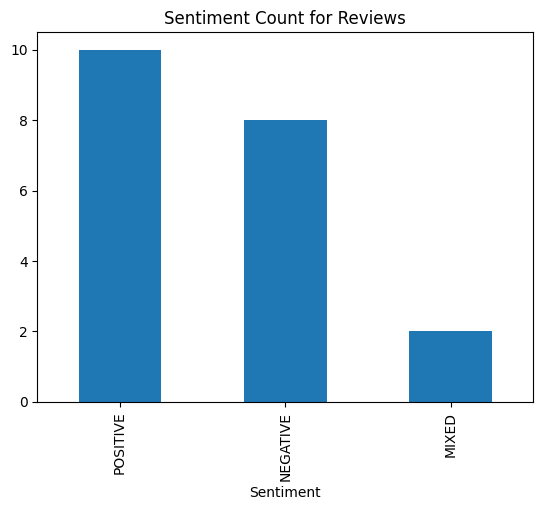

In [29]:
import matplotlib.pyplot as plt

ax1 = Sentiment_DF['Sentiment'].value_counts().plot(kind="bar")
ax1 = plt.title("Sentiment Count for Reviews")
ax1 = plt.xlabel("Sentiment")
 
plt.savefig("sentiment_count.jpg", format='jpg')
 
s3.upload_file('sentiment_count.jpg', 'techcatalyst-public', 'gmastrorilli/sentiment_count.jpg')

In [16]:
# upload file 
Sentiment_DF.to_csv("s3://techcatalyst-public/gmastrorilli/product_sentiment.csv")

# Rekognition

In [3]:
# create comprehend client
rekognition = boto3.client('rekognition',
                          'us-west-2',
                          aws_access_key_id=aws_access_key,
                          aws_secret_access_key=aws_secret_key)

In [42]:
# to get list of images in bucket (only png & jpeg)
def list_images(bucket_name, prefix):
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    image_files = []
    for obj in response.get('Contents', []):
        if obj['Key'].endswith(('.jpeg', '.png', '.jpg')):
            image_files.append(obj['Key'])
    return image_files

bucket_name = 'techcatalyst-public'
prefix = 'resources/license-plates/'
images = list_images(bucket_name, prefix)
images

['resources/license-plates/license_plate10.jpeg',
 'resources/license-plates/license_plate11.png',
 'resources/license-plates/license_plate12.jpeg',
 'resources/license-plates/license_plate13.jpeg',
 'resources/license-plates/license_plate3.png',
 'resources/license-plates/license_plate4.jpeg',
 'resources/license-plates/license_plate6.jpeg',
 'resources/license-plates/license_plate7.jpg',
 'resources/license-plates/license_plate8.png',
 'resources/license-plates/license_plate9.jpeg']

In [11]:
states = pd.read_csv('s3://techcatalyst-public/resources/license-plates/states.csv')
states.head()

,0
0,Alabama
1,Alaska
2,Arizona
3,Arkansas
4,California


In [67]:
bucket_name = 'techcatalyst-public'

detected_text = []
for i in images:
    image = {'S3Object': {'Bucket': bucket_name, 'Name': f'{i}'}}
    output = rekognition.detect_text(Image = image)
    detected_text.append(output['TextDetections']) #[0]['DetectedText']
   
detected_text

[[{'DetectedText': 'ARIZONA',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 98.50362396240234,
   'Geometry': {'BoundingBox': {'Width': 0.4936508238315582,
     'Height': 0.07825587689876556,
     'Left': 0.26605865359306335,
     'Top': 0.19211511313915253},
    'Polygon': [{'X': 0.26668664813041687, 'Y': 0.19211511313915253},
     {'X': 0.7597094774246216, 'Y': 0.19995105266571045},
     {'X': 0.7590815424919128, 'Y': 0.2703709900379181},
     {'X': 0.26605865359306335, 'Y': 0.26253506541252136}]}},
  {'DetectedText': 'AL-A',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 41.137046813964844,
   'Geometry': {'BoundingBox': {'Width': 0.0437580831348896,
     'Height': 0.02405497059226036,
     'Left': 0.8918918967247009,
     'Top': 0.19415807723999023},
    'Polygon': [{'X': 0.8918918967247009, 'Y': 0.19415807723999023},
     {'X': 0.9356499910354614, 'Y': 0.19415807723999023},
     {'X': 0.9356499910354614, 'Y': 0.2182130515575409},
     {'X': 0.8918918967247009, 'Y': 0.2182130515